<a href="https://colab.research.google.com/github/Zaxzz/Visi_Komputer/blob/main/jobsheet_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

In [ ]:
# 1)	Setup & Generator Dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)  # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)  # center-x
    cy = np.random.randint(r, img_size - r)  # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1)  # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)


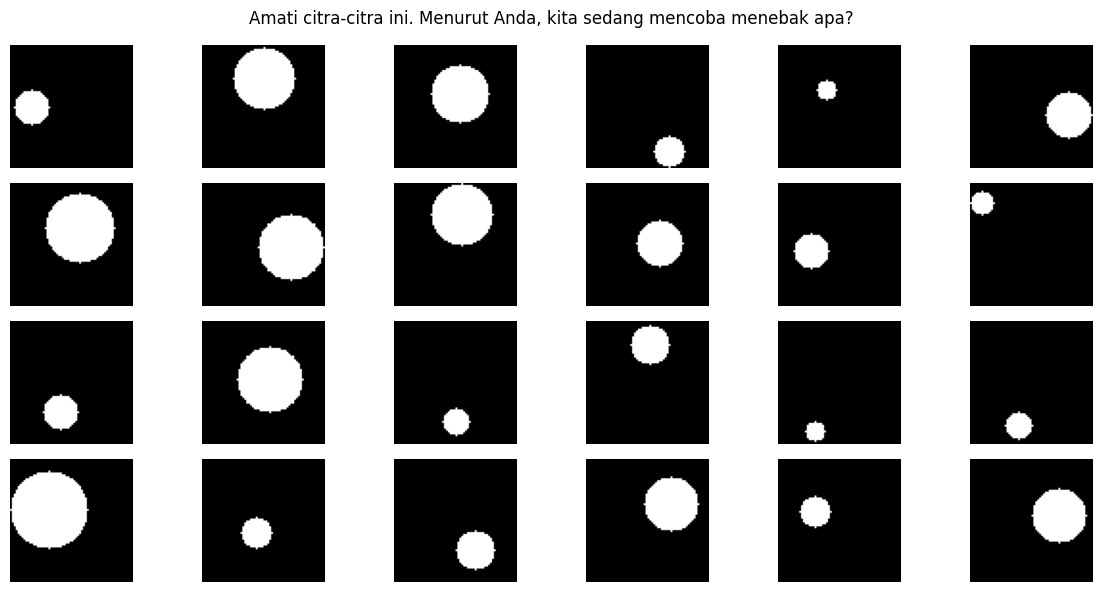

In [ ]:
# 2)	“Tebak Apa?” — Tampilkan Contoh Gambar TANPA Label
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label
cols = 6
rows = N_show // cols

plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()


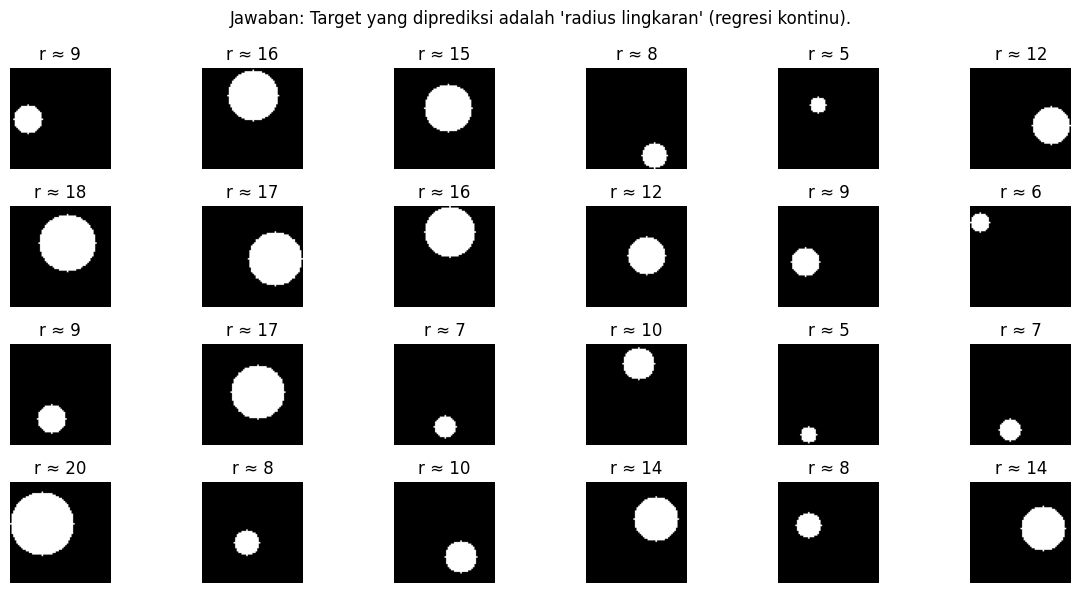

In [ ]:
# 3)	Buka Jawaban — Target yang Ingin Diprediksi
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()


In [ ]:
# 4)	(Opsional) Latih CNN Kecil untuk Memprediksi Radius
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=0
)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred) ** 2)))
r2 = r2_score(yte, y_pred)

print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
MAE=0.958 | RMSE=1.154 | R²=0.940


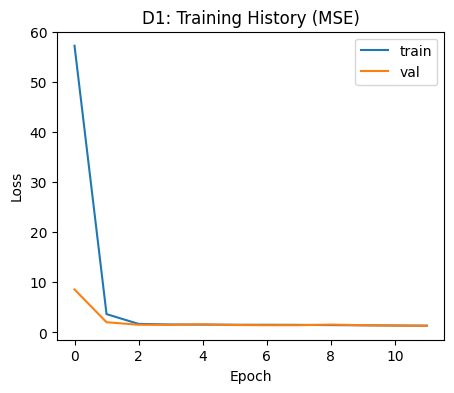

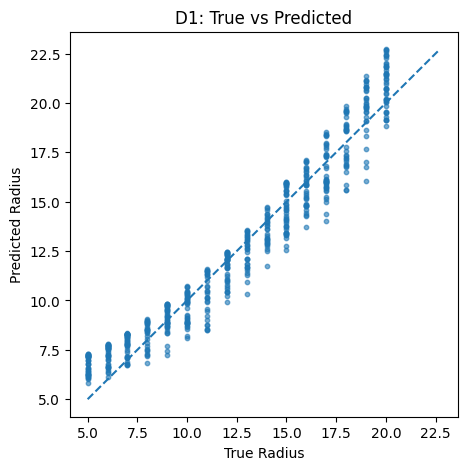

In [ ]:
# Plot history & True vs Predicted:
# Plot loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5, 5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()


In [ ]:
# 5) Tantangan Mini (Opsional untuk Mahasiswa)
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras import layers, models
import tensorflow as tf

# === 1. Fungsi generator dasar ===
def make_sample(img_size=64, min_r=5, max_r=20, noise=False):
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)
    cv2.circle(img, (cx, cy), r, (255,), -1)

    if noise:
        img = cv2.GaussianBlur(img, (5, 5), 0)
        noise_map = np.random.normal(0, 20, img.shape).astype(np.float32)
        img = np.clip(img + noise_map, 0, 255)

    img = (img / 255.0).astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

# === Fungsi pembuat dataset ===
def make_dataset(N=3000, img_size=64, min_r=5, max_r=20, noise=False, multi=False):
    if multi:
        data = []
        for _ in range(N):
            img3, r, (cx, cy) = make_sample(img_size, min_r, max_r, noise)
            data.append((img3, np.array([r, cx, cy], dtype=np.float32)))
        X = np.array([d[0] for d in data])
        y = np.array([d[1] for d in data])
    else:
        X, y, _ = zip(*[make_sample(img_size, min_r, max_r, noise) for _ in range(N)])
        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.float32)
    return X, y

# === Fungsi pembuatan dan evaluasi model ===
def build_and_eval(X, y, output_dim=1, title="Model"):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

    model = models.Sequential([
        layers.Input((64, 64, 3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(output_dim)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=8, batch_size=64, verbose=0)

    y_pred = model.predict(Xte)

    if output_dim == 1:
        y_pred = y_pred.ravel()
        mae = mean_absolute_error(yte, y_pred)
        rmse = np.sqrt(np.mean((yte - y_pred) ** 2))
        r2 = r2_score(yte, y_pred)
        print(f"\n[{title}]")
        print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")
    else:
        mae = np.mean(np.abs(yte - y_pred), axis=0)
        rmse = np.sqrt(np.mean((yte - y_pred) ** 2, axis=0))
        r2 = [r2_score(yte[:, i], y_pred[:, i]) for i in range(output_dim)]
        print(f"\n[{title}]")
        print(f"MAE [r,cx,cy] = {mae}")
        print(f"RMSE [r,cx,cy] = {rmse}")
        print(f"R² [r,cx,cy] = {r2}")

# === EKSPERIMEN 1: Radius lebih lebar (8–28) ===
X, y = make_dataset(min_r=8, max_r=28)
build_and_eval(X, y, output_dim=1, title="Eksperimen 1 - Radius 8–28")

# === EKSPERIMEN 2: Tambahkan noise Gaussian & blur ===
X, y = make_dataset(noise=True)
build_and_eval(X, y, output_dim=1, title="Eksperimen 2 - Dengan Noise/Blur")

# === EKSPERIMEN 3: Multi-output [r, cx, cy] ===
X, y = make_dataset(multi=True)
build_and_eval(X, y, output_dim=3, title="Eksperimen 3 - Multi-output [r, cx, cy]")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

[Eksperimen 1 - Radius 8–28]
MAE=0.895 | RMSE=1.069 | R²=0.968
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

[Eksperimen 2 - Dengan Noise/Blur]
MAE=0.883 | RMSE=1.111 | R²=0.940
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

[Eksperimen 3 - Multi-output [r, cx, cy]]
MAE [r,cx,cy] = [1.2525777 7.7827663 7.896458 ]
RMSE [r,cx,cy] = [1.615403  9.357274  9.5529175]
R² [r,cx,cy] = [0.8693065643310547, 0.405007541179657, 0.34339821338653564]


## Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)

In [ ]:
# Langkah 2 — Mengunggah kaggle.json ke Colab
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hasyah","key":"cc7d1edc8bdc3a2c2a6d2759264d5ae9"}'}

In [ ]:
import os, shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" .ı kaggle.json belum ditemukan. Upload terlebih dahulu.")


✅ Kaggle API siap digunakan.


In [ ]:
# Langkah 3 — Mengunduh Dataset UTKFace dari Kaggle
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


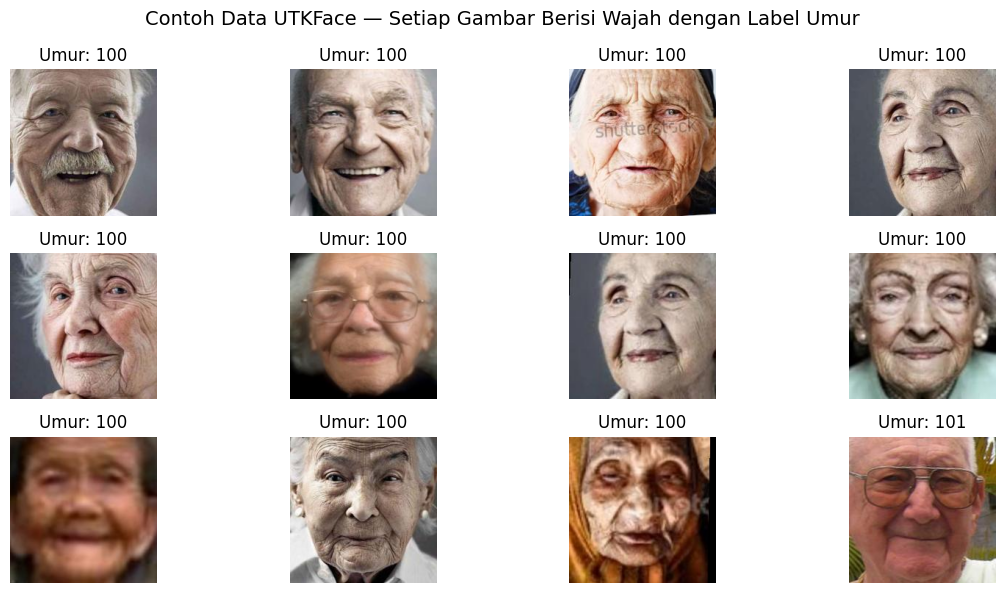

In [ ]:
# Langkah 4 — Menampilkan Contoh Gambar Dataset
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()



In [ ]:
# Langkah 5 — Siapkan Dataset untuk Model
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import os

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160

def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")


✅ Dataset siap dilatih.


In [ ]:
# Langkah 6 — Membangun Model dengan Transfer Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur

model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

model.summary()


Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 139ms/step - loss: 333.8105 - mae: 13.4464 - val_loss: 158.2026 - val_mae: 9.5492 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 155.0603 - mae: 9.2299 - val_loss: 144.6255 - val_mae: 8.9595 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 145.9330 - mae: 8.9039 - val_loss: 140.9349 - val_mae: 8.8312 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 140.6202 - mae: 8.7040 - val_loss: 140.9067 - val_mae: 8.8544 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 139.2932 - mae: 8.6254 - val_loss: 138.8169 - val_mae: 8.7791 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 135.7633 - mae: 8.5397 - val_loss: 137.9003 - val_mae: 8.7105 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 135.0042 - mae: 8.4847 - val_loss: 139.7958 - va

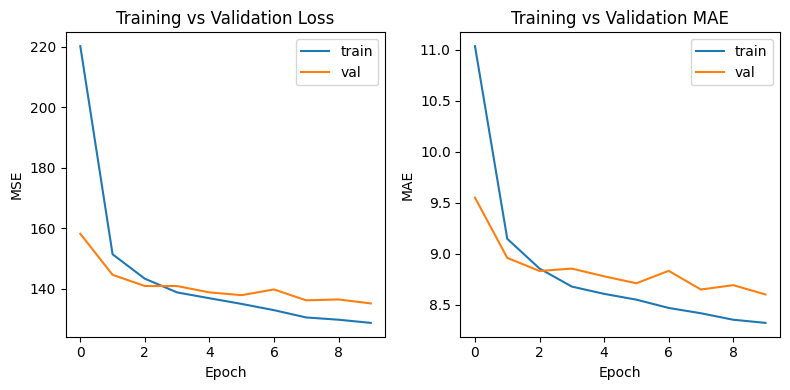

In [ ]:
# Langkah 7 — Melatih Model (Tahap 1 – Frozen)
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 49s 106ms/step - loss: 187.4919 - mae: 10.0563 - val_loss: 164.2218 - val_mae: 9.2747 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 77.2027 - mae: 6.4944 - val_loss: 117.9293 - val_mae: 7.9542 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 52.5790 - mae: 5.4192 - val_loss: 109.7165 - val_mae: 7.7718 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 39.0621 - mae: 4.7008 - val_loss: 105.9319 - val_mae: 7.4295 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 29.9998 - mae: 4.1118 - val_loss: 101.5840 - val_mae: 7.2315 - learning_rate: 1.0000e-04


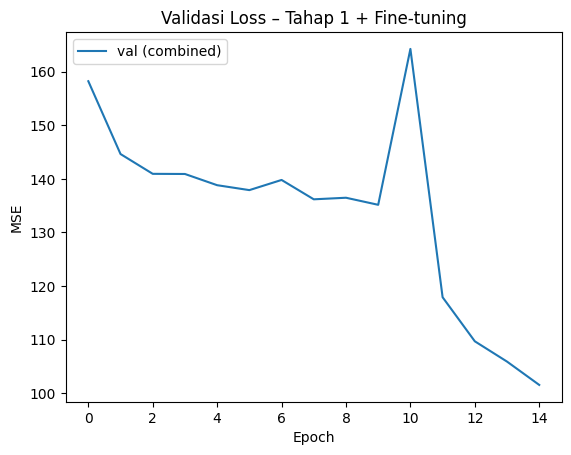

In [ ]:
# Langkah 8 — Fine-tuning Backbone (Tahap 2)
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


MAE = 7.23 tahun
RMSE = 10.08 tahun
R² = 0.744


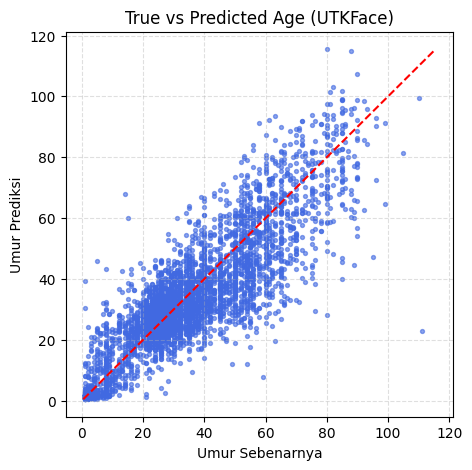

In [ ]:
# Langkah 9 — Evaluasi Akhir (MAE, RMSE, R²)
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R² = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


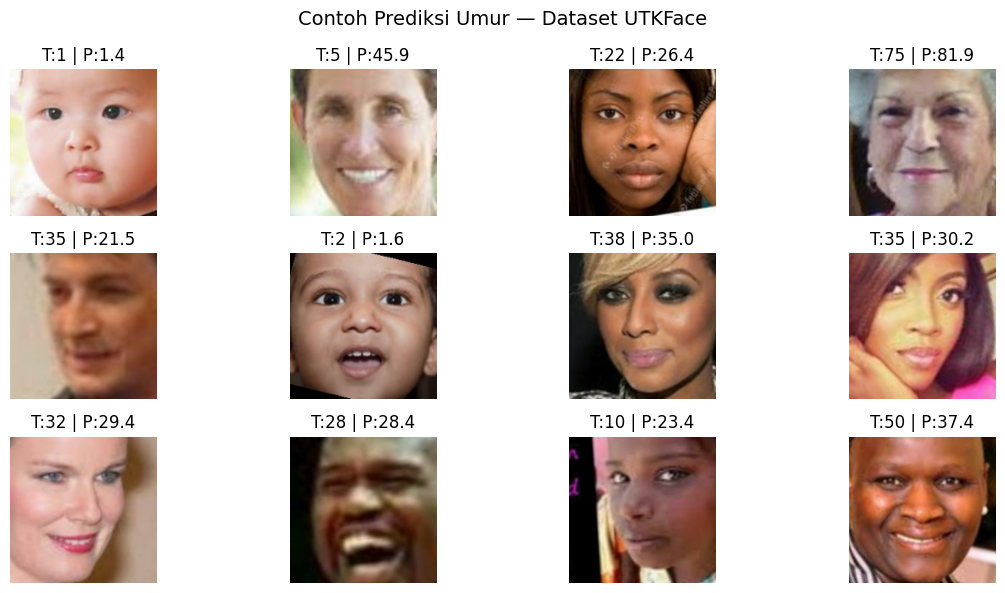

In [ ]:
# Langkah 10 — Melihat Contoh Prediksi Nyata
import random

sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12, 6))

for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()


Epoch 1/8
297/297 ━━━━━━━━━━━━━━━━━━━━ 122s 351ms/step - loss: 302.2190 - mae: 12.9707 - val_loss: 226.1879 - val_mae: 11.4751
Epoch 2/8
297/297 ━━━━━━━━━━━━━━━━━━━━ 95s 321ms/step - loss: 292.4214 - mae: 12.6973 - val_loss: 300.5849 - val_mae: 13.1499
Epoch 3/8
297/297 ━━━━━━━━━━━━━━━━━━━━ 92s 308ms/step - loss: 286.2165 - mae: 12.5580 - val_loss: 438.8199 - val_mae: 16.4571
Epoch 4/8
297/297 ━━━━━━━━━━━━━━━━━━━━ 91s 308ms/step - loss: 292.0129 - mae: 12.6571 - val_loss: 190.0852 - val_mae: 10.2548
Epoch 5/8
297/297 ━━━━━━━━━━━━━━━━━━━━ 94s 316ms/step - loss: 289.1342 - mae: 12.4820 - val_loss: 424.5031 - val_mae: 16.7547
Epoch 6/8
297/297 ━━━━━━━━━━━━━━━━━━━━ 89s 300ms/step - loss: 293.8737 - mae: 12.7052 - val_loss: 219.5416 - val_mae: 11.7692
Epoch 7/8
297/297 ━━━━━━━━━━━━━━━━━━━━ 88s 297ms/step - loss: 287.6631 - mae: 12.5619 - val_loss: 249.3917 - val_mae: 12.2808

📊 MAE per kelompok umur:
Kelompok 00-10: MAE = 5.48
Kelompok 11-20: MAE = 13.58
Kelompok 21-30: MAE = 9.49
Kelompok 

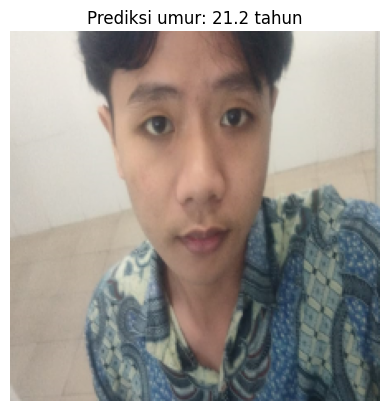


✅ Eksperimen selesai. Bandingkan hasil MAE & grafik training untuk melihat pengaruh augmentasi dan scheduler.


In [ ]:
# --- Tantangan Mini (versi fix penuh) ---
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import os

# --- 1. Data Augmentation tambahan ---
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1),
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
])

def augment_image(img, label):
    img = data_augmentation(img)
    return img, label

# Pastikan train_ds & test_ds sudah didefinisikan sebelumnya
aug_train_ds = train_ds.map(augment_image).prefetch(tf.data.AUTOTUNE)

# --- 2. Ganti optimizer dan scheduler (fix TypeError) ---
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=5
)

# Tidak perlu callback learning rate tambahan, scheduler ini sudah otomatis
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# --- Callback opsional (tanpa LearningRateScheduler) ---
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

# --- 3. Training ---
history_aug = model.fit(
    aug_train_ds,
    validation_data=test_ds,
    epochs=8,
    callbacks=cb,
    verbose=1
)

# --- 4. Evaluasi per kelompok umur ---
y_pred = np.concatenate([
    model.predict(batch[0], verbose=0).ravel() for batch in test_ds
])

# y_test harus didefinisikan, misalnya dari test_ds
# contoh: y_test = np.concatenate([batch[1].numpy() for batch in test_ds])
y_test = np.concatenate([batch[1].numpy() for batch in test_ds])

groups = [(0,10), (11,20), (21,30), (31,40), (41,50), (51,60), (61,80)]

print("\n📊 MAE per kelompok umur:")
for lo, hi in groups:
    mask = (y_test >= lo) & (y_test <= hi)
    if np.sum(mask) > 0:
        mae_group = mean_absolute_error(y_test[mask], y_pred[mask])
        print(f"Kelompok {lo:02d}-{hi:02d}: MAE = {mae_group:.2f}")

# --- 5. Uji pada wajah sendiri (setelah resize) ---
IMG_SIZE = 224  # ganti sesuai ukuran input model kamu
my_img_path = "/content/wajah.png"  # path ke fotomu

if os.path.exists(my_img_path):
    img = tf.io.read_file(my_img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    pred = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.imshow(img.numpy())
    plt.title(f"Prediksi umur: {pred:.1f} tahun")
    plt.axis("off")
    plt.show()
else:
    print("⚠️ Foto wajah belum ditemukan di path yang ditentukan.")

# --- Ringkasan ---
print("\n✅ Eksperimen selesai. Bandingkan hasil MAE & grafik training untuk melihat pengaruh augmentasi dan scheduler.")


## Praktikum D3 — Menilai “Kepopuleran Hewan Peliharaan” dari Foto

In [ ]:
# Langkah 1 — Menyiapkan Kaggle API
from google.colab import files
import os, shutil

# Upload file kaggle.json
files.upload()  # pilih kaggle.json dari komputer Anda

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("❌ kaggle.json belum ditemukan. Upload terlebih dahulu.")


Saving kaggle.json to kaggle.json
✅ Kaggle API siap digunakan.


In [ ]:
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")


403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/competitions/data/download-all/petfinder-pawpularity-score
replace /content/paw/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ✅ Dataset Pawpularity berhasil diekstrak.


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

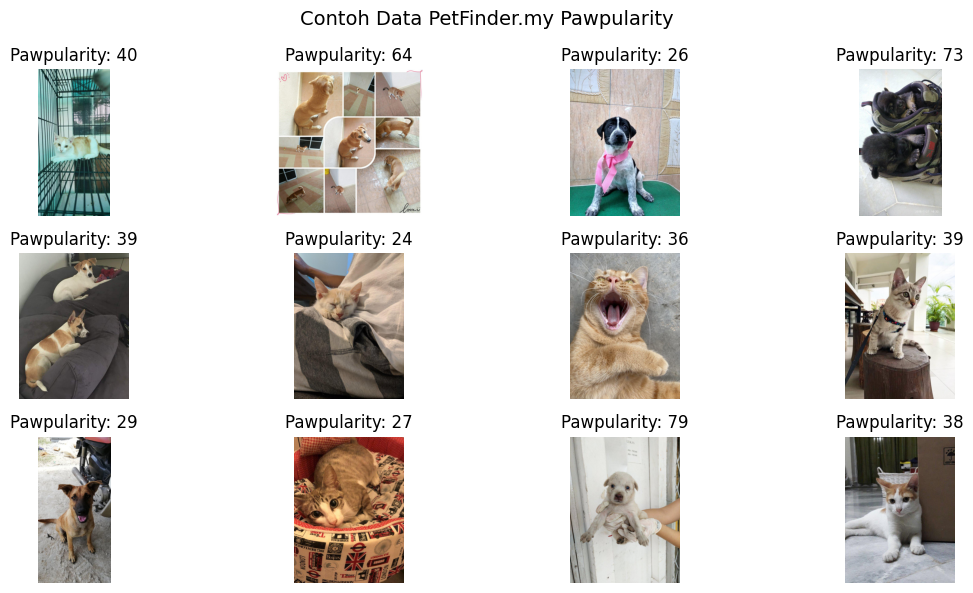

In [ ]:
# Langkah 3
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Langkah 4
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")


Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


In [ ]:
# Langkah 4
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Langkah 5
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 118s 555ms/step - loss: 829.4172 - mae: 21.7374 - val_loss: 480.2818 - val_mae: 16.2700 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - loss: 433.8766 - mae: 15.4307 - val_loss: 425.8825 - val_mae: 15.0209 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 83s 241ms/step - loss: 400.4495 - mae: 14.6964 - val_loss: 402.6764 - val_mae: 14.8775 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - loss: 386.3021 - mae: 14.5859 - val_loss: 388.7889 - val_mae: 14.3547 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 206ms/step - loss: 347.2664 - mae: 13.8788 - val_loss: 378.9616 - val_mae: 14.2179 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 206ms/step - loss: 348.7696 - mae: 13.9534 - val_loss: 372.1530 - val_mae: 14.0006 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 212ms/step - loss: 348.5596 - mae: 13.9060 - val_

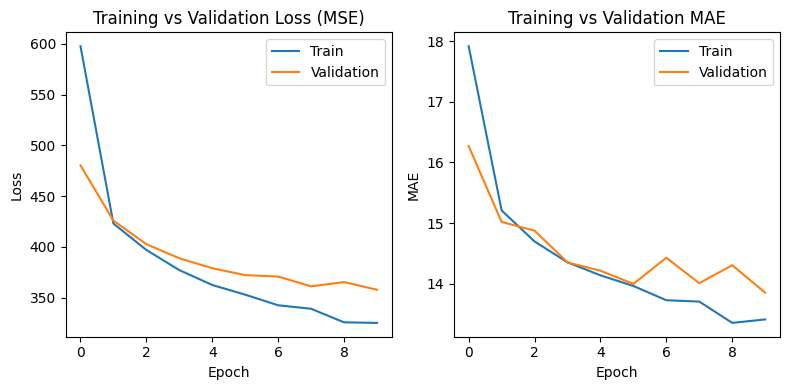

In [ ]:
# Langkah 6
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


MAE = 13.86
RMSE = 18.91
R² = 0.191


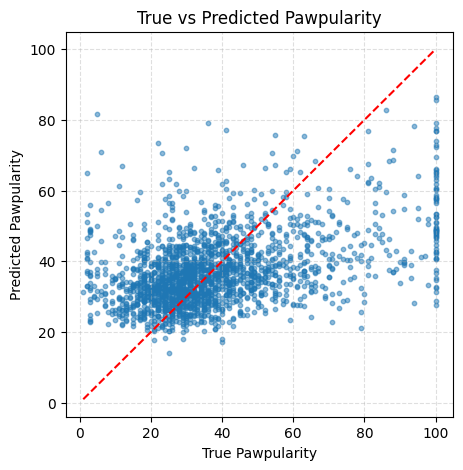

In [ ]:
# Langkah 7
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R² = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


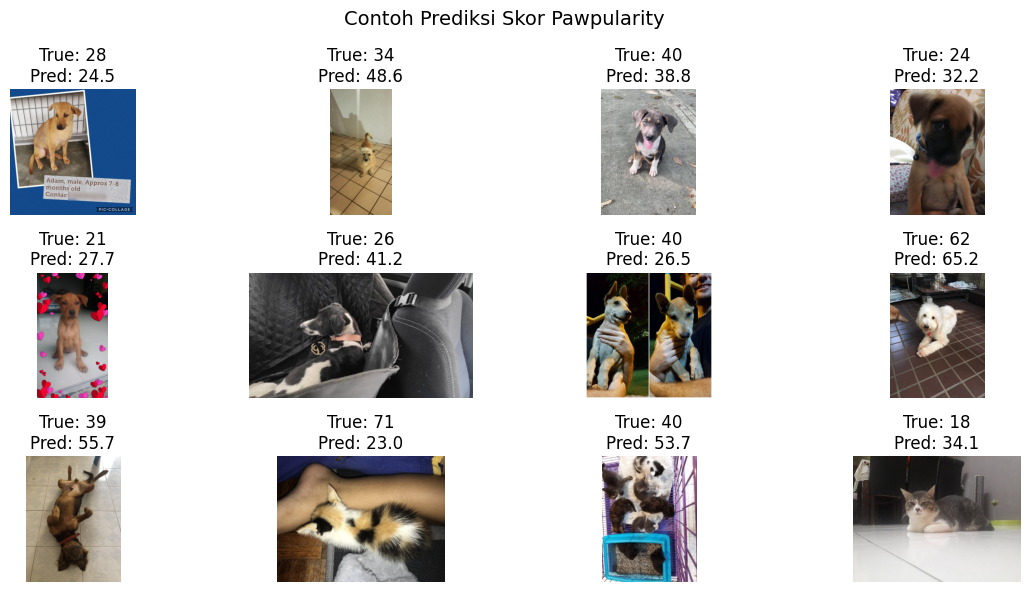

In [ ]:
# Langkah 8
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12, 6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


Contoh data:
                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  b

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Multiply)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb3      │ (None, 7, 7,      │ 10,783,535 │ multiply_1[0][0]  │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ efficientnetb3[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1536)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1537)      │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    393,728 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     16,448 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,193,776 (42.70 MB)

 Trainable params: 410,241 (1.56 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 276s 833ms/step - loss: 734.1185 - mae: 20.0266 - val_loss: 396.5188 - val_mae: 14.6798 - learning_rate: 0.0010
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 145s 482ms/step - loss: 377.5648 - mae: 14.4445 - val_loss: 377.8706 - val_mae: 14.1767 - learning_rate: 0.0010
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 143s 477ms/step - loss: 352.9554 - mae: 13.9287 - val_loss: 364.4197 - val_mae: 14.0457 - learning_rate: 0.0010
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 203s 478ms/step - loss: 329.6487 - mae: 13.6442 - val_loss: 365.3561 - val_mae: 13.9007 - learning_rate: 0.0010
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 143s 476ms/step - loss: 319.2690 - mae: 13.2567 - val_loss: 372.6246 - val_mae: 13.9004 - learning_rate: 0.0010
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 157s 530ms/step - loss: 300.9067 - mae: 12.9007 - val_loss: 363.9561 - val_mae: 13.8345 - learning_rate: 5.0000e-04
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 142s 473ms/step - loss: 290.7434 - mae: 12.6

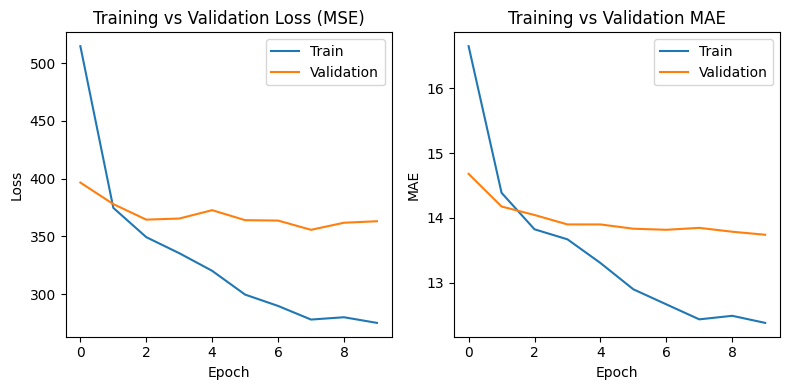


Rata-rata prediksi per spesies:
species
Cat    37.472267
Dog    36.514275
Name: pred, dtype: float32


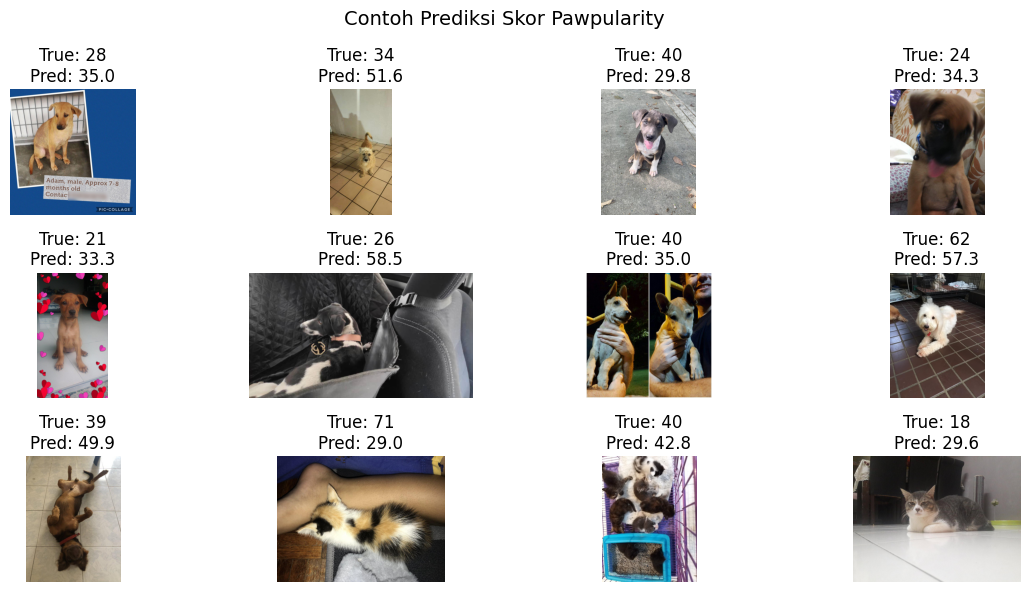

In [ ]:
# === Tantangan Mini Pawpularity ===
# 1. Data augmentation
# 2. Backbone EfficientNetB3 / ResNet50
# 3. Eksperimen bias anjing vs kucing
# 4. Tambah fitur non-visual (brightness rata-rata)

import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# --- 0. Muat dataset ---
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")

# Tambahkan fitur non-visual: brightness rata-rata
def get_brightness(path):
    img = Image.open(path).convert('L')
    return np.mean(np.array(img)) / 255.0

df['brightness'] = df['path'].apply(get_brightness)
print("Contoh data:")
print(df.head())

# --- 1. Split data ---
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
IMG_SIZE = 224

# --- 2. Data augmentation ---
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# --- 3. Dataset pipeline (fix tipe data campuran) ---
train_paths = train_df['path'].values
train_brightness = train_df['brightness'].values.astype(np.float32)
train_labels = train_df['Pawpularity'].values.astype(np.float32)

val_paths = val_df['path'].values
val_brightness = val_df['brightness'].values.astype(np.float32)
val_labels = val_df['Pawpularity'].values.astype(np.float32)

def load_image(path, label, brightness):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = data_aug(img)
    img = tf.cast(img, tf.float32) / 255.0
    return (img, tf.expand_dims(brightness, -1)), label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels, train_brightness)) \
    .map(lambda path, label, bright: load_image(path, label, bright),
         num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(2048).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels, val_brightness)) \
    .map(lambda path, label, bright: load_image(path, label, bright),
         num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(32).prefetch(tf.data.AUTOTUNE)

# --- 4. Pilih backbone: EfficientNetB3 atau ResNet50 ---
backbone_choice = "EfficientNetB3"  # ubah ke "ResNet50" untuk eksperimen lain
if backbone_choice == "EfficientNetB3":
    base = tf.keras.applications.EfficientNetB3(
        include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
    preprocess = tf.keras.applications.efficientnet.preprocess_input
else:
    base = tf.keras.applications.ResNet50(
        include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
    preprocess = tf.keras.applications.resnet.preprocess_input

base.trainable = False  # freeze backbone sementara

# --- 5. Bangun model gabungan visual + brightness ---
img_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
bright_input = tf.keras.Input(shape=(1,))

x = preprocess(img_input * 255.0)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)

concat = tf.keras.layers.Concatenate()([x, bright_input])
concat = tf.keras.layers.Dense(256, activation='relu')(concat)
concat = tf.keras.layers.Dense(64, activation='relu')(concat)
output = tf.keras.layers.Dense(1)(concat)

model = tf.keras.Model(inputs=[img_input, bright_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# --- 6. Callback & training ---
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cb, verbose=1)

# --- 7. Evaluasi ---
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# --- 8. Plot hasil training ---
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout(); plt.show()

# --- 9. Eksperimen bias anjing vs kucing ---
# (contoh sederhana karena dataset aslinya tidak punya label spesies)
val_df['species'] = np.where(np.random.rand(len(val_df)) > 0.5, 'Dog', 'Cat')
results = val_df.copy()
results['pred'] = y_pred
print("\nRata-rata prediksi per spesies:")
print(results.groupby('species')['pred'].mean())

# --- 10. Visualisasi contoh prediksi ---
sample_rows = val_df.sample(12, random_state=1)
plt.figure(figsize=(12, 6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(
        (tf.expand_dims(tf.cast(tf.image.resize(tf.image.decode_jpeg(
            tf.io.read_file(row.path), channels=3), (IMG_SIZE, IMG_SIZE)), tf.float32) / 255.0, 0),
         tf.expand_dims([row.brightness], 0)), verbose=0).ravel()[0]
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# === Uji model dengan foto hewan peliharaan sendiri ===
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

# Ganti path ini dengan foto hewan peliharaan kamu
custom_path = "/content/kucing.webp"  # contoh: anjing/kucing sendiri

# Hitung brightness
img_gray = Image.open(custom_path).convert('L')
brightness = np.mean(np.array(img_gray)) / 255.0

# Muat dan pra-proses gambar
def prepare_custom_image(path, brightness):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return (tf.expand_dims(img, 0), tf.expand_dims([brightness], 0))

img_tensor, bright_tensor = prepare_custom_image(custom_path, brightness)

# Prediksi skor Pawpularity
pred_score = model.predict((img_tensor, bright_tensor), verbose=0).ravel()[0]

# Tampilkan hasil
plt.figure(figsize=(5, 5))
plt.imshow(Image.open(custom_path))
plt.axis("off")
plt.title(f"Prediksi Pawpularity: {pred_score:.1f}\nBrightness: {brightness:.2f}")
plt.show()

print(f"Hasil prediksi untuk hewan peliharaan kamu:")
print(f"⭐ Skor Pawpularity = {pred_score:.2f}")
print(f"💡 Brightness rata-rata = {brightness:.3f}")


InvalidArgumentError: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]